/home/daniel/anaconda3/envs/invertible_kernel_PCA/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


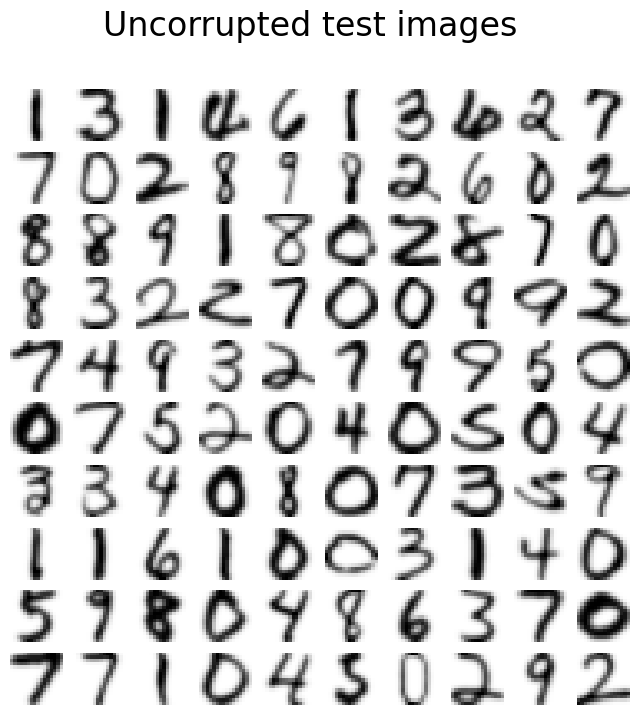

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    stratify=y, 
                                                    random_state=0, 
                                                    train_size=1_000, 
                                                    test_size=1_000)
noise_scale = 0.25
eval_fun = lambda x_, x_hat_: np.mean((x_ - x_hat_) ** 2)  # MSE

def plot_digits(x, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(x, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

plot_digits(x_test, "Uncorrupted test images")

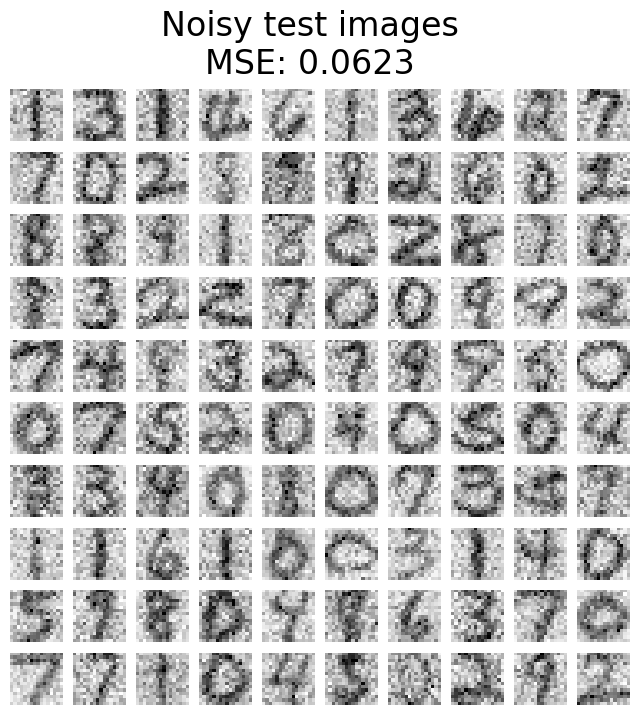

In [2]:
rng = np.random.RandomState(0)
noise = rng.normal(scale=noise_scale, size=x_test.shape)
x_test_noisy = x_test + noise

noise = rng.normal(scale=noise_scale, size=x_train.shape)
x_train_noisy = x_train + noise
plot_digits(x_test_noisy, f"Noisy test images\nMSE: {eval_fun(x_test, x_test_noisy):.4f}")

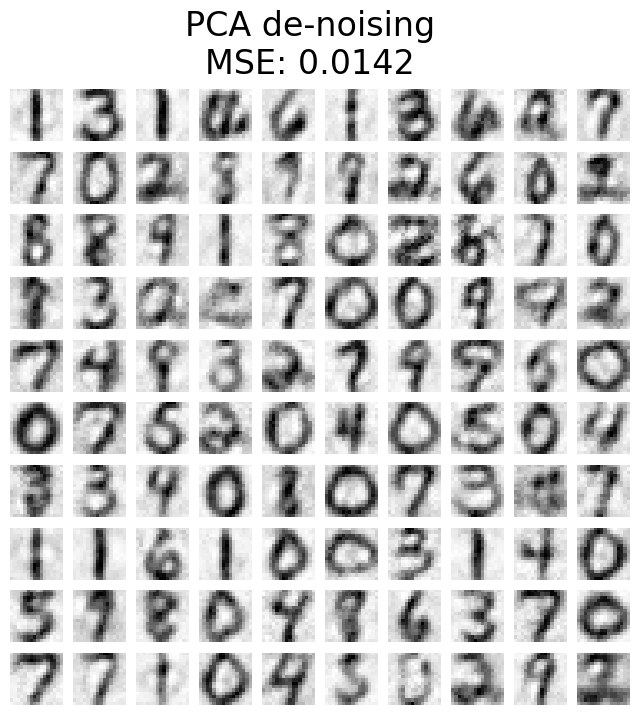

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25)
pca.fit(x_train_noisy)
x_reconstructed_pca = pca.inverse_transform(pca.transform(x_test_noisy))
plot_digits(x_reconstructed_pca,f"PCA de-noising\nMSE: {eval_fun(x_test, x_reconstructed_pca):.4f}",)

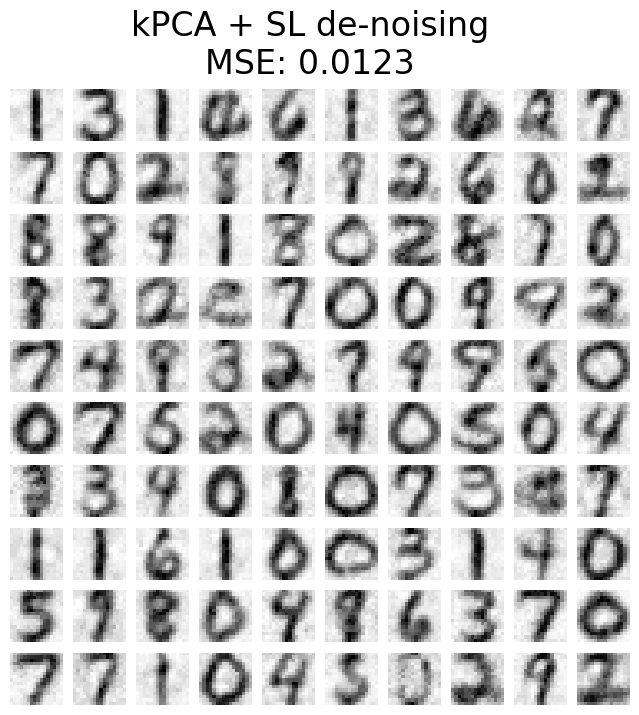

In [4]:
from sklearn.decomposition import KernelPCA
kernel_pca = KernelPCA(n_components=50,
                       kernel="rbf",
                       gamma=5e-3,
                       fit_inverse_transform=True,
                       alpha=1e-2)
kernel_pca.fit(x_train_noisy)
x_reconstructed_kernel_pca = kernel_pca.inverse_transform(kernel_pca.transform(x_test_noisy))
plot_digits(
    x_reconstructed_kernel_pca,
    "kPCA + SL de-noising\n"
    f"MSE: {eval_fun(x_test, x_reconstructed_kernel_pca):.4f}",
)

In [5]:
class PartiallyInvertibleOperation:
    def transform(self, x):
        # should return `f(x), info`
        # where f(x) is a function of f,
        # info is a dict containing information to invert the function
        pass

    def invert_transform(self, fx, info):
        pass  # should revert the initial operation, i.e., `invert_transform(*transform(x)) = x`

In [6]:
class Cos(PartiallyInvertibleOperation):
    # Cosine is not entirely invertible, but here, we divide it into an invertible
    # and a non-invertible part in such a way that if called in sequence `invert_transform(*transform(x)) = x`
    def transform(self, angle):
        main_component = angle % (2 * np.pi)
        k = angle // (2 * np.pi)
        p = np.where((main_component > np.pi), 1, 0)
        return np.cos(main_component), {'k': k * 2 * np.pi, 'p': p}

    def invert_transform(self, fx, info):
        fx_bounded = np.minimum(np.maximum(fx, -1), 1)
        angle = np.where(info['p'], 2 * np.pi - np.arccos(fx_bounded), np.arccos(fx_bounded))
        return angle + info['k']


class Sin(PartiallyInvertibleOperation):
    def __init__(self):
        # same as Cos but shifted by pi/2
        self.cos = Cos()

    def transform(self, angle):
        return self.cos.transform(np.pi / 2 - angle)

    def invert_transform(self, fx, info):
        angle_aux = self.cos.invert_transform(fx, info)
        return np.pi / 2 - angle_aux

In [7]:
import scipy.linalg as linalg


class AffineTransform(PartiallyInvertibleOperation):
    def __init__(self, A, b, regularization=0):
        self.A = A
        self.b = b
        self.regularization = regularization
        self.m, self.n = A.shape
        if self.m < self.n:
            raise ValueError('Only works whe A raises the dimension of the input vector')
        m, = b.shape
        if self.m != m:
            raise ValueError('b has the wrong dimension')

        if regularization > 0:
            # Ridge regularization
            self.A_pinv = np.linalg.inv(self.A.T @ self.A + regularization * np.eye(self.n)) @ self.A.T

        else:
            # Precompute factorization, so it can efficiently compute least square solution afterwards
            self.u, self.s, self.vh = linalg.svd(A, full_matrices=False, compute_uv=True)

    def transform(self, x):
        return x @ self.A.T + self.b, None

    def invert_transform(self, fx, _info):
        # Solve least square problem x = ||A @ x - (fx-b)|| , i.e., compute x = pinv(A) @ (fx - b)
        y = fx - self.b
        if self.regularization > 0:
            x = y @ self.A_pinv.T
        else:
            x = ((1 / self.s) * (y @ self.u)) @ self.vh  # == pinv(self.A)
        return x

In [8]:
class RBFSampler(PartiallyInvertibleOperation):
    """Invertible version of RBF sampler from sklearn"""

    def __init__(self, n_features, gamma=1.0, n_components=100, random_state=None, regularization=0):
        rng = np.random.RandomState(random_state)
        random_weights_ = np.sqrt(2 * gamma) * rng.normal(size=(n_components, n_features))
        random_offset_ = rng.uniform(0, 2 * np.pi, size=n_components)
        self.aff = AffineTransform(random_weights_, random_offset_, regularization)
        self.cos = Cos()
        self.n_features = n_features
        self.gamma = gamma
        self.n_components = n_components
        self.random_state = random_state
        self.regularization = regularization

    def transform(self, x):
        x1, _ = self.aff.transform(x)
        z, info = self.cos.transform(x1)
        return np.sqrt(2.0) / np.sqrt(self.n_components) * z, info

    def invert_transform(self, f_x, info):
        f_x_rescaled = np.sqrt(self.n_components) / np.sqrt(2.0) * f_x
        f_x1 = self.cos.invert_transform(f_x_rescaled, info)
        x = self.aff.invert_transform(f_x1, None)
        return x

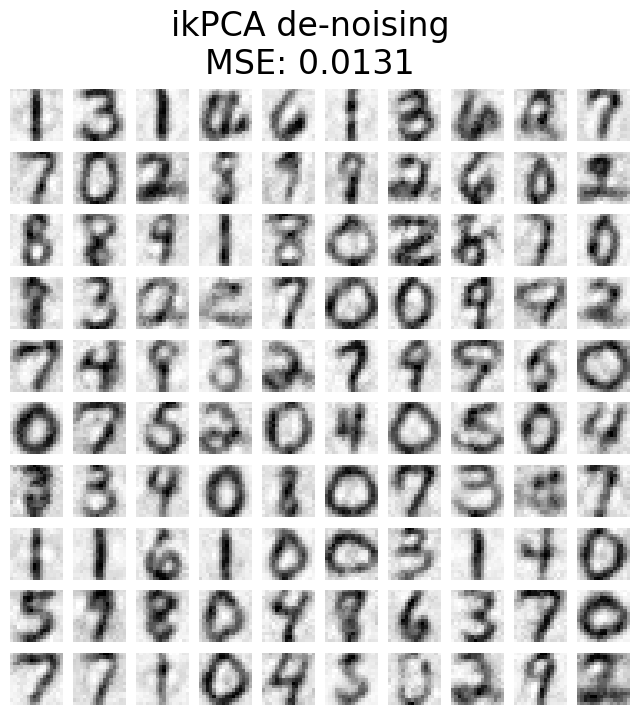

In [9]:
pca_ = PCA(n_components=25)
sampler = RBFSampler(x_test.shape[1], n_components=40_000, gamma=5e-4)

x_train_transformed, _ = sampler.transform(x_train_noisy)
pca_.fit(x_train_transformed)

x_test_transformed, info = sampler.transform(x_test_noisy)
x_reconstructed_pca_transformed = pca_.inverse_transform(pca_.transform(x_test_transformed))
x_reconstructed_pca = sampler.invert_transform(x_reconstructed_pca_transformed , info)

plot_digits(
    x_reconstructed_pca,
    f"ikPCA de-noising\nMSE: {eval_fun(x_test,x_reconstructed_pca):.4f}",
)